In [132]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
from keras.layers.normalization import BatchNormalization

tb_hist = TensorBoard(log_dir='./graphFINAL', histogram_freq=0, write_graph=True, write_images=True)
chanDim = -1

# Load Dataset

In [133]:
import glob

In [134]:
imgs = glob.glob('./mrlEyes_2018_01/*/*.png')

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
train_imgs, test_imgs = train_test_split(imgs, test_size=0.15)

In [137]:
len(train_imgs), len(test_imgs)

(72163, 12735)

In [138]:
train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.18)

In [139]:
len(train_imgs), len(valid_imgs), len(test_imgs)

(59173, 12990, 12735)

In [140]:
from collections import Counter
from PIL import Image

In [141]:
x_train = np.empty((len(train_imgs), 32, 32, 1))
y_train = np.empty(len(train_imgs))

x_valid = np.empty((len(valid_imgs), 32, 32, 1))
y_valid = np.empty(len(valid_imgs))

x_test = np.empty((len(test_imgs), 32, 32, 1))
y_test = np.empty(len(test_imgs))

In [142]:
for idx, train in enumerate(train_imgs):
    x_train[idx] = np.expand_dims(np.array(Image.open(train).resize((32, 32), Image.BICUBIC)), -1)
    y_train[idx] = int(train.split('/')[-1].split('_')[4])

In [143]:
for idx, valid in enumerate(valid_imgs):
    x_valid[idx] = np.expand_dims(np.array(Image.open(valid).resize((32, 32), Image.BICUBIC)), -1)
    y_valid[idx] = int(valid.split('/')[-1].split('_')[4])

In [144]:
for idx, test in enumerate(test_imgs):
    x_test[idx] = np.expand_dims(np.array(Image.open(test).resize((32, 32), Image.BICUBIC)), -1)
    y_test[idx] = int(test.split('/')[-1].split('_')[4])

In [145]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((59173, 32, 32, 1),
 (59173,),
 (12990, 32, 32, 1),
 (12990,),
 (12735, 32, 32, 1),
 (12735,))

# Preview

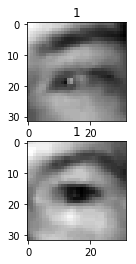

In [146]:
plt.subplot(2, 1, 1)
plt.title(str(int(y_train[0])))
plt.imshow(x_train[0].reshape((32, 32)), cmap='gray')
print("\n")
plt.subplot(2, 1, 2)
plt.title(str(int(y_valid[4])))
plt.imshow(x_valid[4].reshape((32, 32)), cmap='gray')

# Data Augmentation

In [147]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)


valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

valid_generator = valid_datagen.flow(
    x=x_valid, y=y_valid,
    batch_size=32,
    shuffle=True
)

test_generator = test_datagen.flow(
    x=x_test, y=y_test,
    batch_size=32,
    shuffle=True
)

# Build Model

In [148]:
inputs = Input(shape=(32, 32, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)
net = BatchNormalization(axis=chanDim)(net)
net = Dropout(0.25)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)
net = BatchNormalization(axis=chanDim)(net)
net= Dropout(0.25)(net)


net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)
net = BatchNormalization(axis=chanDim)(net)
net = Dropout(0.25)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = BatchNormalization()(net)
net = Dropout(0.5)(net)


#classifier
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

plot_model(model, to_file = './model_plot.png', show_shapes =True, show_layer_names=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 64)          0         
__________

5개의 layer를 가진 모델

# Train

In [149]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
epochs_num = 50
hist = model.fit_generator(
    train_generator, epochs= epochs_num , validation_data=valid_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='valid_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='valid_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05), tb_hist
    ]
)

Epoch 1/50
1850/1850 [==============================] - 27s 15ms/step - loss: 0.3442 - acc: 0.8515 - val_loss: 0.1043 - val_acc: 0.9627
Epoch 2/50
   9/1850 [..............................] - ETA: 26s - loss: 0.1717 - acc: 0.9444

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with valid_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `valid_acc` which is not available. Available metrics are: val_acc,loss,val_loss,lr,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1850/1850 [==============================] - 26s 14ms/step - loss: 0.1628 - acc: 0.9376 - val_loss: 0.0987 - val_acc: 0.9717
Epoch 3/50
1850/1850 [==============================] - 26s 14ms/step - loss: 0.1305 - acc: 0.9509 - val_loss: 0.0967 - val_acc: 0.9701
Epoch 4/50
1850/1850 [==============================] - 26s 14ms/step - loss: 0.1177 - acc: 0.9568 - val_loss: 0.0823 - val_acc: 0.9711
Epoch 5/50
1850/1850 [==============================] - 26s 14ms/step - loss: 0.1058 - acc: 0.9621 - val_loss: 0.1037 - val_acc: 0.9623
Epoch 6/50
1850/1850 [==============================] - 26s 14ms/step - loss: 0.0991 - acc: 0.9636 - val_loss: 0.0622 - val_acc: 0.9790
Epoch 7/50
1850/1850 [==============================] - 26s 14ms/step - loss: 0.0961 - acc: 0.9650 - val_loss: 0.0716 - val_acc: 0.9768
Epoch 8/50
1850/1850 [==============================] - 26s 14ms/step - loss: 0.0939 - acc: 0.9663 - val_loss: 0.0445 - val_acc: 0.9841
Epoch 9/50
1850/1850 [==============================] - 26s

In [150]:
model.save('models/train_mrl_%s.h5' %(epochs_num))

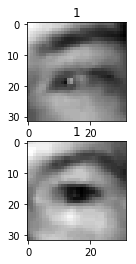

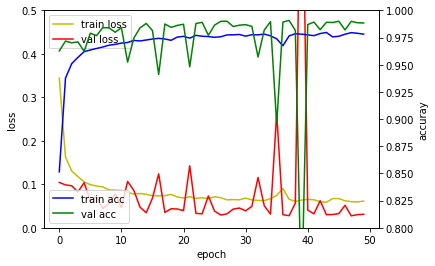

In [151]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.title(str(int(y_train[0])))
plt.imshow(x_train[0].reshape((32, 32)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(int(y_valid[4])))
plt.imshow(x_valid[4].reshape((32, 32)), cmap='gray')


fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.8, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [152]:
scores = model.evaluate_generator(test_generator, steps=10)
print("## evaluation ##")
print(scores)
print("##  accuracy  ##")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

## evaluation ##
[0.03786788074066862, 0.9875]
##  accuracy  ##
acc: 98.75%


In [153]:
scores = model.evaluate_generator(test_generator)
print("## evaluation ##")
print(scores)
print("##  accuracy  ##")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

## evaluation ##
[0.03276001149091927, 0.988064389477817]
##  accuracy  ##
acc: 98.81%


In [154]:
#start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
#
#model.fit_generator(
#    train_generator, epochs=50, validation_data=valid_generator,
#    callbacks=[
#        ModelCheckpoint('models/%s.h5' % (start_time), monitor='valid_acc', save_best_only=True, mode='max', verbose=1),
#        ReduceLROnPlateau(monitor='valid_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
#    ]
#)

In [155]:
#model.save('models/train_mrl_0.h5')

In [131]:
#model.save(‘train_mrl_0.hdf5’)

In [95]:
#history['loss'], history['val_loss']

# Confusion Matrix

In [ ]:
#from sklearn.metrics import accuracy_score, confusion_matrix
#import seaborn as sns

#model = load_model('models/%s.h5' % (start_time))

#y_pred = model.predict(x_val/255.)
#y_pred_logical = (y_pred > 0.5).astype(np.int)

#print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
#cm = confusion_matrix(y_val, y_pred_logical)
#sns.heatmap(cm, annot=True)

# Distribution of Prediction

In [ ]:
#ax = sns.distplot(y_pred, kde=False)

---

# MobileNet V2

In [ ]:
#from keras.applications import MobileNetV2

In [ ]:
#model = MobileNetV2(input_shape=(32, 32, 1), include_top=True, weights=None, classes=2)

In [ ]:
#model.summary()